# MVA strategy

In [101]:
# from typing import Dict, Optional
import pandas as pd
from pypfopt import EfficientFrontier
from datetime import datetime

from data.data_loader import PykrxDataLoader
from simulation.account import Account
from simulation.broker import Broker
from simulation.utility import ticker_to_name, get_lookback_fromdate
from simulation.utility import rebalance
from simulation.metric import cagr, mdd, sharpe_ratio, sortino_ratio
from simulation.visualize import (plot_cumulative_return, plot_single_period_return,
                                  plot_relative_single_period_return,
                                  plot_cumulative_asset_profit, plot_asset_weight)

In [102]:
def calculate_MA(ohlcv_data: pd.DataFrame,
                 period: int,
                 ma_type: str) -> pd.DataFrame:
    # 종가 데이터 만들기
    close_data = ohlcv_data[['close', 'ticker']].reset_index().set_index(
        ['ticker', 'date']).unstack(level=0) # unstack -> 종목코드를 열로 설정, 종가를 값으로, 날짜를 인덱스로 정렬
    close_data = close_data['close']

    # 이동평균 계산하기
    if ma_type == 'sma':
        ma = close_data.rolling(window=period).mean()
    elif ma_type == 'ema':
        ma = close_data.ewm(span=period).mean()
    else:
        raise ValueError

    return ma


def get_moving_average_weights(ohlcv_data: pd.DataFrame,
                               ma_data: pd.DataFrame) -> Optional[Dict]:
    # 이동평균 데이터 중 결측치가 있는지 확인함
    if ma_data.isnull().values.any():
        return None

    # 포트폴리오 및 구매 주식 변수 정의
    portfolio = {}
    stocks_to_buy = []

    # 매수할 주식과 매도할 주식을 선정함
    for ticker in ohlcv_data['ticker']:
        # 종가 > 이동평균
        if ohlcv_data.loc[ohlcv_data['ticker'] == ticker, 'close'].values > ma_data[ticker]:
            stocks_to_buy.append(ticker) # 매입 
        # 종가 <= 이동평균
        else:
            portfolio[ticker] = 0.0 # 0 = 매도

    # 매수할 주식이 없는 경우 포트폴리오 반환
    if not stocks_to_buy:
        return portfolio

    # 매수할 주식 비율을 할당함
    weights = 1 / len(stocks_to_buy)
    for ticker in stocks_to_buy:
        portfolio[ticker] = weights

    return portfolio

In [106]:
def simulate_moving_average(ohlcv_data: pd.DataFrame,
                          ma_type: str,
                          period: int) -> Account:
    # 1. 계좌 및 브로커 선언
    account = Account(initial_cash=100000000) #초기금 설정
    broker = Broker() #브로커 설정

    # 2. 이동평균 계산
    ma = calculate_MA(ohlcv_data=ohlcv_data, period=period, ma_type=ma_type)

    for date, ohlcv in ohlcv_data.groupby(['date']):
        date = date[0]  # 튜플에서 첫 번째 요소를 가져옵니다.(date.date()의 경우 반환값 오류 문제 발생) 이후에서는 date[0]으로 처리
        print(date.date())

        # 3. 주문 집행 및 계좌 갱신
        transactions = broker.process_order(dt=date, data=ohlcv, orders=account.orders)
        account.update_position(transactions=transactions)
        account.update_portfolio(dt=date, data=ohlcv)
        account.update_order()

        # 4. 이동평균 전략을 이용하여 포트폴리오 구성
        ma_slice = ma.loc[date]
        weights = get_moving_average_weights(ohlcv_data=ohlcv, ma_data=ma_slice)

        print(f'Portfolio: {weights}')
        if weights is None:
            continue

        # 5. 주문
        rebalance(dt=date, data=ohlcv, account=account, weights=weights)

    return account

In [104]:
# 데이터 시작과 끝 날짜 정의
fromdate = '2020-01-01'
todate = '2025-01-11'

# 투자할 종목 후보 정의
ticker_list = ['005930', '000660', '207940',
               '051910', '006400', '005380',
               '000270', '005490', '035420']

# 이동평균 기간 정의
period = 3

# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=period, freq='m') # moving average = 3 month

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)

# 데이터 확인하기
ohlcv_data.head()

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/Users/jh/Desktop/PyRA/data/data_loader.py:116: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.



,ticker,open,high,low,close,volume
date,,,,,,
2019-10-31,000270,41950,43100,41950,42550,1226642
2019-11-30,000270,42150,44800,41800,43250,18030352
2019-12-31,000270,43300,45650,42150,44300,16584597
2020-01-31,000270,44100,44300,39950,40900,24817954
2020-02-29,000270,40200,42300,36000,36250,22325910


In [107]:
# 이동평균 종류 정의
ma_type = 'sma'  # {ema, sma}

# 단순이동평균 전략 실행하기
sma_simulation_account = simulate_moving_average(ohlcv_data=ohlcv_data, ma_type=ma_type, period=period)

2019-10-31
Portfolio: None
2019-11-30
Portfolio: None
2019-12-31
Portfolio: {'005380': 0.0, '000270': 0.125, '000660': 0.125, '005490': 0.125, '005930': 0.125, '006400': 0.125, '035420': 0.125, '051910': 0.125, '207940': 0.125}
2020-01-31
Portfolio: {'000270': 0.0, '005490': 0.0, '000660': 0.14285714285714285, '005380': 0.14285714285714285, '005930': 0.14285714285714285, '006400': 0.14285714285714285, '035420': 0.14285714285714285, '051910': 0.14285714285714285, '207940': 0.14285714285714285}
2020-02-29
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '035420': 0.0, '006400': 0.3333333333333333, '051910': 0.3333333333333333, '207940': 0.3333333333333333}
2020-03-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 1.0}
2020-04-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005930': 0.0, '005490': 0.2, '006400': 0.2, '035420': 0.2, '051910': 0.2

In [108]:
# 이동평균 종류 정의
ma_type = 'ema'  # {ema, sma}

# 지수이동평균 전략 실행하기
ema_simulation_account = simulate_moving_average(ohlcv_data=ohlcv_data, ma_type=ma_type, period=period)

2019-10-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2019-11-30
Portfolio: {'000660': 0.0, '005380': 0.0, '005930': 0.0, '051910': 0.0, '207940': 0.0, '000270': 0.25, '005490': 0.25, '006400': 0.25, '035420': 0.25}
2019-12-31
Portfolio: {'005380': 0.0, '000270': 0.125, '000660': 0.125, '005490': 0.125, '005930': 0.125, '006400': 0.125, '035420': 0.125, '051910': 0.125, '207940': 0.125}
2020-01-31
Portfolio: {'000270': 0.0, '005490': 0.0, '000660': 0.14285714285714285, '005380': 0.14285714285714285, '005930': 0.14285714285714285, '006400': 0.14285714285714285, '035420': 0.14285714285714285, '051910': 0.14285714285714285, '207940': 0.14285714285714285}
2020-02-29
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '035420': 0.0, '006400': 0.3333333333333333, '051910': 0.3333333333333333, '207940': 0.3333333333333333}
2020-03-31
Portfolio: {'000270': 

In [109]:
#데이터 형식 변환, 룩백 기간 제거
sma_account = pd.DataFrame(sma_simulation_account.account_history).set_index('date')
sma_portfolio = pd.DataFrame(sma_simulation_account.portfolio_history).set_index('date')

ema_account = pd.DataFrame(ema_simulation_account.account_history).set_index('date')
ema_portfolio = pd.DataFrame(ema_simulation_account.portfolio_history).set_index('date')

analysis_fromdate = sma_account.index[period]

In [110]:
#sma 단기 수익률 계산
sma_returns = sma_account['total_asset'].pct_change().loc[analysis_fromdate:]
sma_returns.name = 'sma_return'
sma_returns.head()

date
2020-01-31    0.016812
2020-02-29   -0.014792
2020-03-31   -0.101731
2020-04-30    0.203595
2020-05-31    0.092566
Name: sma_return, dtype: float64

In [111]:
#ema 단기 수익률 계산
ema_returns = ema_account['total_asset'].pct_change().loc[analysis_fromdate:]
ema_returns.name = 'ema_returns'
ema_returns.head()

date
2020-01-31    0.017626
2020-02-29   -0.014889
2020-03-31   -0.101555
2020-04-30    0.203932
2020-05-31    0.121615
Name: ema_returns, dtype: float64

In [112]:
#KOSPI 월간 수익률 계산(비교집단)
kospi = data_loader.load_index_data(ticker_list=['1001'], freq='m', delay=1)
kospi_returns = kospi['close'].pct_change().loc[analysis_fromdate:]
kospi_returns.iloc[0] = 0.0
kospi_returns.name = 'kospi_return'
kospi_returns.index.name = 'date'
kospi_returns.head()

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



date
2020-01-31    0.000000
2020-02-29   -0.062293
2020-03-31   -0.116945
2020-04-30    0.109948
2020-05-31    0.042125
Freq: ME, Name: kospi_return, dtype: float64

In [113]:
#성능 지표
#CAGR
print("CAGR")
print(cagr(returns=sma_returns, freq='m'))
print(cagr(returns=ema_returns, freq='m'))
print(cagr(returns=kospi_returns, freq='m'))
#MDD(Maximum Drawdown)
print("MDD")
print(mdd(returns=sma_returns))
print(mdd(returns=ema_returns))
print(mdd(returns=kospi_returns))
#Sharpe Ratio
print("Sharpe Ratio")
print(sharpe_ratio(returns=sma_returns, freq='m'))
print(sharpe_ratio(returns=ema_returns, freq='m'))
print(sharpe_ratio(returns=kospi_returns, freq='m'))
#Sortino Ratio
print("Sortino Ratio")
print(sortino_ratio(returns=sma_returns, freq='m'))
print(sortino_ratio(returns=ema_returns, freq='m'))
print(sortino_ratio(returns=kospi_returns, freq='m'))

CAGR
0.08869447500308425
0.09654864440855904
0.03434052026457968
MDD
-0.4637538490689953
-0.44697198230317514
-0.3461634128881175
Sharpe Ratio
0.4482921104178017
0.47429364030951765
0.2677429529533142
Sortino Ratio
0.5253027147487436
0.5559012423836435
0.26684997514882025


cumulative return curve


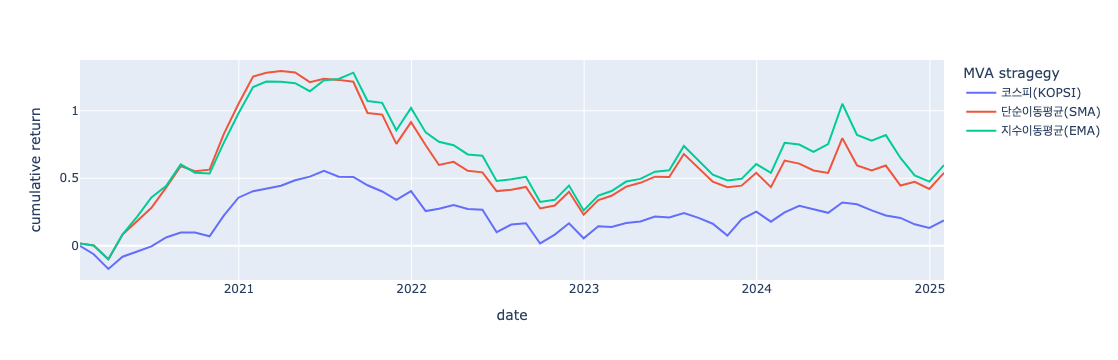

In [114]:
#누적 수익률 지표
print("cumulative return curve")
# 누적 수익률 계산하기
benchmark_cum_returns = (kospi_returns + 1).cumprod() - 1
sma_cum_returns = (sma_returns + 1).cumprod() - 1
ema_cum_returns = (ema_returns + 1).cumprod() - 1

# 자산 정보 결합하기
cum_returns = pd.concat([benchmark_cum_returns, sma_cum_returns, ema_cum_returns], axis=1)
cum_returns.columns = ["코스피(KOPSI)", "단순이동평균(SMA)", "지수이동평균(EMA)"]

# 자산 변화 시각화하기
fig = px.line(data_frame=cum_returns)

# x축, y축 레이블 설정
fig.update_xaxes(title_text='date')
fig.update_yaxes(title_text='cumulative return')

# 범례 제목 설정
fig.update_layout(legend_title_text='MVA stragegy') 

fig.show()

cumulative return curve


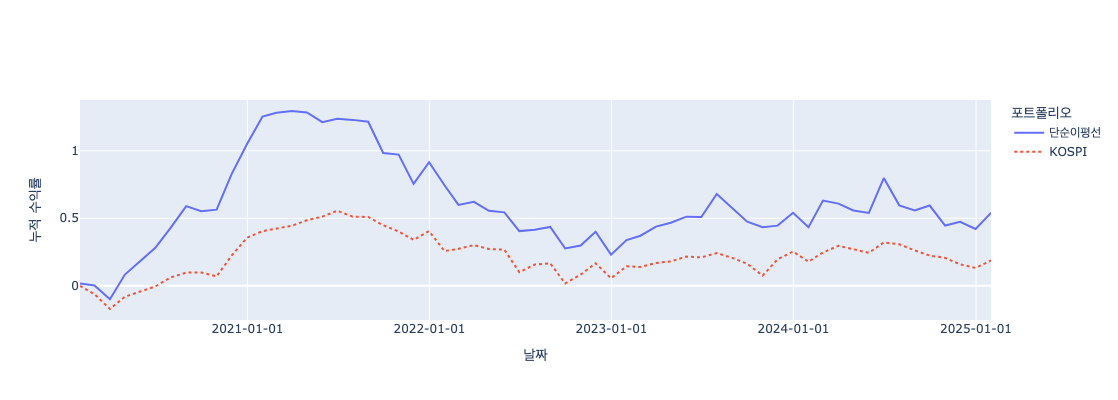

single period return bar


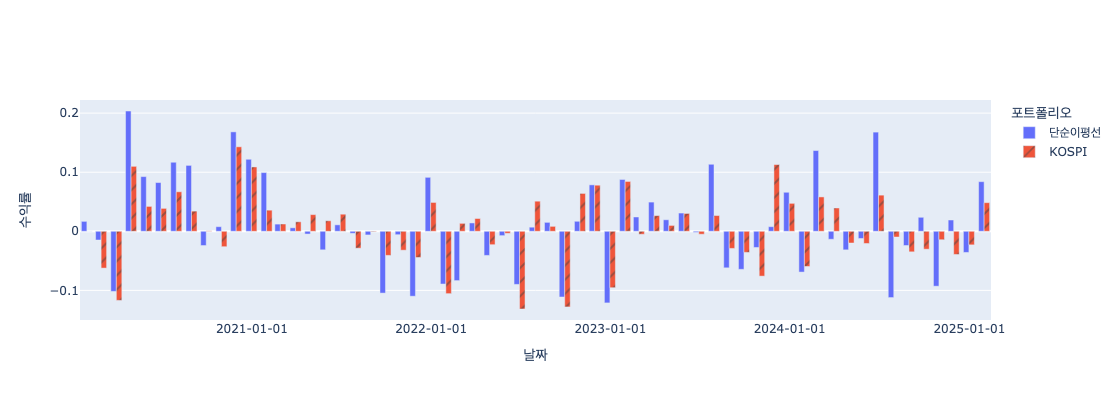

In [115]:
#시각화 분석
print("cumulative return curve")
plot_cumulative_return(returns=sma_returns, benchmark_returns=kospi_returns,
                       strategy_name='단순이평선',
                       benchmark_name='KOSPI')
print("single period return bar")
plot_single_period_return(returns=sma_returns, benchmark_returns=kospi_returns,
                          strategy_name='단순이평선',
                          benchmark_name='KOSPI')